In [1]:
import numpy as np
import tensorflow as tf
import os
import sys
from gensim.models import Word2Vec
import math

**Define functions**

In [2]:
# Create placeholders
X = tf.placeholder(shape=(None, None), dtype=tf.int32)
Y = tf.placeholder(shape=(None), dtype=tf.int32)

In [3]:
# Create RNN
def get_init_cell(batch_size, rnn_size):
    """
    Create an RNN Cell and initialize it.
        :param batch_size: Size of batches
        :param rnn_size: Size of RNNs
        :return: Tuple (cell, initialize state)
    """
    lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(rnn_size)
    initial_state = lstm_cell.zero_state(batch_size, dtype=tf.float32)
    return lstm_cell, initial_state

def build_rnn(cell, inputs, num_classes):
    outputs, final_state = tf.nn.dynamic_rnn(cell, inputs, dtype=tf.float32)
    logits = tf.contrib.layers.fully_connected(outputs, num_classes, 
                                               activation_fn=None,
                                               weights_initializer=tf.truncated_normal_initializer(stddev=0.1),
                                               biases_initializer=tf.zeros_initializer)
    return logits, final_state

In [4]:
# Create loss function
def loss_function(labels, logits):
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits)
    return tf.reduce_mean(loss)

**Get data**

In [5]:
import pickle
with open('../data/embedding_matrix.npy', 'r') as f:
    embedding_matrix = pickle.load(f)
embedding_matrix.shape

(81434, 100)

In [6]:
# Create embedding lookup
embeddings = tf.constant(embedding_matrix, dtype=tf.float32)
X_embedded = tf.nn.embedding_lookup(embeddings, X)
X_embedded.shape

TensorShape([Dimension(None), Dimension(None), Dimension(100)])

In [7]:
with open('../data/train_batch.npy', 'r') as f:
    train = pickle.load(f)

with open('../data/valid_batch.npy', 'r') as f:
    valid = pickle.load(f)
    
with open('../data/test_data.npy', 'r') as f:
    test = pickle.load(f)
    
train_batch_data, train_batch_labels = train['data'], train['labels']
valid_batch_data, valid_batch_labels = valid['data'], valid['labels']
test_data, test_labels = test['data'], test['labels']

**Build the graph**

In [8]:
num_classes = 21
num_epochs = 15
batch_size = 32
learning_rate = 0.001
rnn_size = 100

In [9]:
lstm_cell, initial_state = get_init_cell(tf.shape(X)[0], rnn_size)
logits, final_state = build_rnn(lstm_cell, X_embedded, num_classes)
logits = logits[:,-1,:]
probs = tf.nn.softmax(logits)
cost = loss_function(Y, logits)
train_op = tf.train.AdamOptimizer(learning_rate).minimize(cost)

**Train**

In [10]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [11]:
train_loss_history, valid_loss_history = [], []

In [12]:
%%time
for epoch in range(num_epochs):
    print("Epoch {}".format(epoch))
    state = sess.run(initial_state, {X: train_batch_data[10][:64]})
    iterations = 0
    for key in train_batch_data:
        total_data = len(train_batch_data[key])
        num_batches = int(math.ceil(total_data/float(batch_size)))
        train_loss = 0
        for batch in range(num_batches):
            train_x = train_batch_data[key][batch*batch_size:(batch+1)*batch_size]
            train_y = train_batch_labels[key][batch*batch_size:(batch+1)*batch_size]
            train_y = train_y.reshape(train_y.shape[0])
            feed = {X: train_x,
                    Y: train_y,
                    initial_state: state}
            t_loss, state, _ = sess.run([cost, final_state, train_op], feed)
            train_loss += t_loss
            iterations += 1
    train_loss = train_loss/iterations
    print("Training Loss: {}".format(train_loss))
    train_loss_history.append(train_loss)
    
    # Validation Loss
    valid_loss = 0
    for key in valid_batch_data:
        feed = {X: valid_batch_data[key],
                Y: valid_batch_labels[key],
                initial_state: state}
        v_loss = sess.run(cost, feed)
        valid_loss += v_loss
    valid_loss = valid_loss/len(valid_batch_data)
    print("Validation Loss: {}".format(valid_loss))
    valid_loss_history.append(valid_loss)

Epoch 0
Training Loss: 0.00103627372528
Validation Loss: 0.412224358618
Epoch 1
Training Loss: 0.000360021860314
Validation Loss: 0.138930102019
Epoch 2
Training Loss: 0.000101715873477
Validation Loss: 0.0745713533787
Epoch 3
Training Loss: 6.63036035111e-05
Validation Loss: 0.0582519684976
Epoch 4
Training Loss: 4.58338238622e-05
Validation Loss: 0.0493895545782
Epoch 5
Training Loss: 2.92274860368e-05
Validation Loss: 0.0474537885048
Epoch 6
Training Loss: 1.355854811e-05
Validation Loss: 0.0462275409124
Epoch 7
Training Loss: 9.01927024316e-06
Validation Loss: 0.04659284083
Epoch 8
Training Loss: 9.93057899603e-06
Validation Loss: 0.0450686198669
Epoch 9
Training Loss: 7.90549431664e-06
Validation Loss: 0.0420636774369
Epoch 10
Training Loss: 6.19575670469e-06
Validation Loss: 0.0399298551232
Epoch 11
Training Loss: 5.19621794907e-06
Validation Loss: 0.0397577340457
Epoch 12
Training Loss: 6.58657302817e-06
Validation Loss: 0.0433061839761
Epoch 13
Training Loss: 4.97369467549e-06


**Looks like the model has too much overfitting. The loss has gone down to $10^{-6}$ range while validation loss is still in $10^{-2}$ range.**

In [13]:
predictions = []
for ind, test_i in enumerate(test_data):
    test_i = np.reshape(test_i, (1,-1))
    if test_i.shape[1] > 0:
        p = sess.run(probs, {X: test_i})
        predictions.append(np.argmax(p[0]))
    else:
        predictions.append(-1)
predictions = np.array(predictions)
print(sum(predictions == test_labels)/float(len(test_labels)))

0.0022380952380952382


In [17]:
import matplotlib.pyplot as plt
%matplotlib inline 

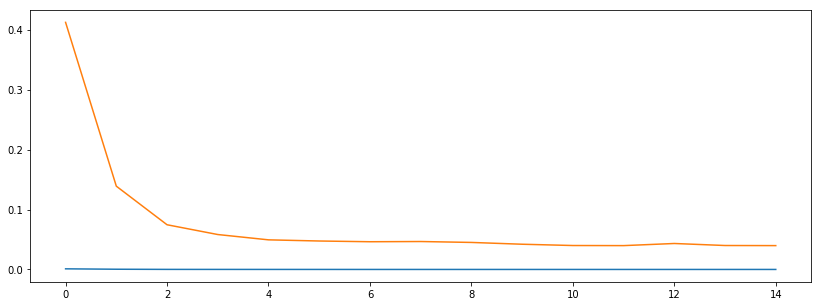

In [26]:
plt.figure(figsize=(14, 5))
plt.plot(train_loss_history)
plt.plot(valid_loss_history)
min_y = min(min(valid_loss_history),min(train_loss_history))
max_y = max(max(valid_loss_history),max(train_loss_history))

plt.show()